# L_006: Optimizing Optimizers

## At a glance

## S1 - Fusion: Combining Operations for Efficiency

Key Terms:

1) Role of Optimizers
2) Inefficiency of Sequential Processing
3) Fusion: Combining Operations for Efficiency
4) Pointer Management and Memory Domains
5) Hardware Constraints

- 1) Role of Optimizers - Optimizers are algorithms used during the training of neural networks to adjust the model's parameters (weights) in order to reduce the error (loss).
- 2) Inefficiency of Sequential Processing - A naive loop over each parameter (or each element) leads to many small operations, each incurring kernel launch overhead, which is costly on the GPU.
- 3) Fusion: Combining Operations for Efficiency 
  - Multi-Tensor Apply: A technique that processes a list of tensors at once, reducing the number of kernel launches from m×n to just n or fewer.

- 4) Pointer Management and Memory Domains
  - Pointers and Data Allocation:
Each tensor’s data is allocated on the GPU using cudaMalloc, resulting in device pointers.
  - Host vs. Device:
Although the device pointers (addresses) point to GPU memory, an array containing these pointers is initially stored in host memory.
  - The Problem:
Passing a host-resident pointer-to-pointer (e.g., float**) directly to a kernel causes illegal memory access because the GPU cannot access host memory.
  - The Solution:
Package the pointer array into a struct or explicitly copy it to device memory (using cudaMemcpy), ensuring that the GPU kernel can safely access the pointer values and, consequently, the tensor data.

- 5) Hardware Constraints:
  -  Kernel Argument Space Limit:
There is a 4KB limit on the arguments that can be passed to a CUDA kernel, which necessitates batching or splitting the operations if too many pointers are involved.

## S2 -  Technical challenges

1. Unified Memory
2. Horizontal vs. Vertical Fusion

- 1. Unified Memory - Unified memory allows GPU threads to access data that is allocated in CPU memory. It maps the CPU memory into the GPU’s address space.
- 2. Horizontal vs. Vertical Fusion 
    - Vertical Fusion (Operation Fusion) - Combines multiple sequential operations (e.g., A + B → C, followed by C * 2 → D) into a single kernel.
      - Eliminates intermediate memory reads/writes between operations.
    - Horizontal Fusion (Batched Fusion) - Processes multiple independent data instances (e.g., A1 + B1, A2 + B2, ...) in a single kernel launch.
      - Eliminates looping over kernel launches for batched workloads.


# S1 - Fusion: Combining Operations for Efficiency


## S1.1-3 - Sequential processing over each parameter vs. Fusion Operations

In [1]:
import os
os.environ['TORCH_CUDA_ARCH_LIST'] = "9.0"

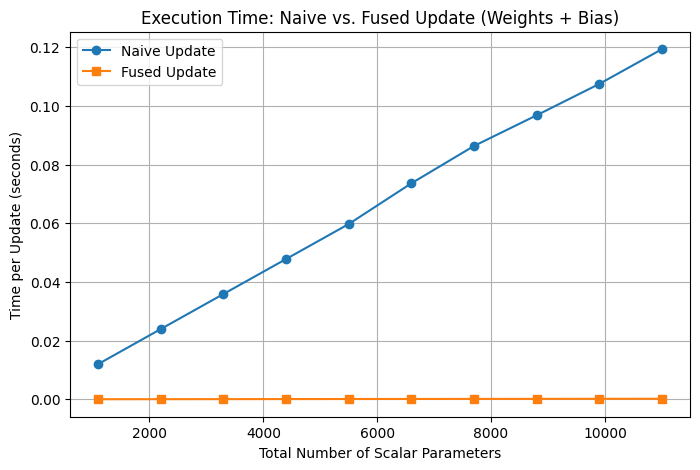

In [2]:
import time
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define the naive update: update weights and biases element-by-element using loops.
def naive_update(weights, biases, weight_grads, bias_grads, lr):
    updated_weights = []
    updated_biases = []
    
    # Update weights (each weight_matrix is a 10x10 tensor)
    for w, gw in zip(weights, weight_grads):
        updated_w = torch.empty_like(w)
        for r in range(w.shape[0]):
            for c in range(w.shape[1]):
                updated_w[r, c] = w[r, c] - lr * gw[r, c]
        updated_weights.append(updated_w)
    
    # Update biases (each bias_vector is a 10-element vector)
    for b, gb in zip(biases, bias_grads):
        updated_b = torch.empty_like(b)
        for i in range(b.shape[0]):
            updated_b[i] = b[i] - lr * gb[i]
        updated_biases.append(updated_b)
    
    return updated_weights, updated_biases

# Define the fused update: perform vectorized updates for weights and biases.
def fused_update(weights, biases, weight_grads, bias_grads, lr):
    # Update weights (stack and then update 10x10 tensors)
    stacked_weights = torch.stack(weights)           # Shape: (N_stack_dimension, 10, 10)
    stacked_weight_grads = torch.stack(weight_grads) # Shape: (N_stack_dimension, 10, 10)
    updated_stacked_weights = stacked_weights - lr * stacked_weight_grads
    updated_weights = list(torch.unbind(updated_stacked_weights, dim=0))
    
    # Update biases (stack and update 10-element vectors)
    stacked_biases = torch.stack(biases)           # Shape: (N_stack_dimension, 10)
    stacked_bias_grads = torch.stack(bias_grads)   # Shape: (N_stack_dimension, 10)
    updated_stacked_biases = stacked_biases - lr * stacked_bias_grads
    updated_biases = list(torch.unbind(updated_stacked_biases, dim=0))
    
    return updated_weights, updated_biases

# Simulation parameters
lr = 0.01
n_iter = 100    # number of iterations per experiment

# Each parameter group consists of:
# - Weight_matrix: 10x10 tensor (100 scalars)
# - Bias_vector: 10-element vector (10 scalars)
# Total scalars per group = 100 + 10 = 110
H, W = 10, 10
bias_len = 10
scalars_per_group = H * W + bias_len  # 110 scalar parameters per group

# We'll run experiments with a fixed number of parameter groups (here 100 for demonstration).
group_counts = np.linspace(10, 100, 10, dtype=int)
naive_times = []
fused_times = []

torch.manual_seed(0)

for count in group_counts:
    # Create lists of weight tensors, bias vectors, and their corresponding gradients.
    weights = [torch.rand(H, W) for _ in range(count)]
    biases = [torch.rand(bias_len) for _ in range(count)]
    weight_grads = [torch.rand(H, W) for _ in range(count)]
    bias_grads = [torch.rand(bias_len) for _ in range(count)]
    
    # Warm-up to avoid cold-start overhead.
    _ = naive_update(weights, biases, weight_grads, bias_grads, lr)
    _ = fused_update(weights, biases, weight_grads, bias_grads, lr)
    
    # Time the naive update
    start_time = time.perf_counter()
    for _ in range(n_iter):
        naive_update(weights, biases, weight_grads, bias_grads, lr)
    elapsed_naive = time.perf_counter() - start_time
    naive_times.append(elapsed_naive / n_iter)
    
    # Time the fused update
    start_time = time.perf_counter()
    for _ in range(n_iter):
        fused_update(weights, biases, weight_grads, bias_grads, lr)
    elapsed_fused = time.perf_counter() - start_time
    fused_times.append(elapsed_fused / n_iter)

# Calculate total number of scalar parameters: (number of groups) * (110 scalars per group)
total_scalar_params = group_counts * scalars_per_group

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(total_scalar_params, naive_times, marker='o', label='Naive Update')
plt.plot(total_scalar_params, fused_times, marker='s', label='Fused Update')
plt.xlabel('Total Number of Scalar Parameters')
plt.ylabel('Time per Update (seconds)')
plt.title('Execution Time: Naive vs. Fused Update (Weights + Bias)')
plt.legend()
plt.grid(True)
plt.show()

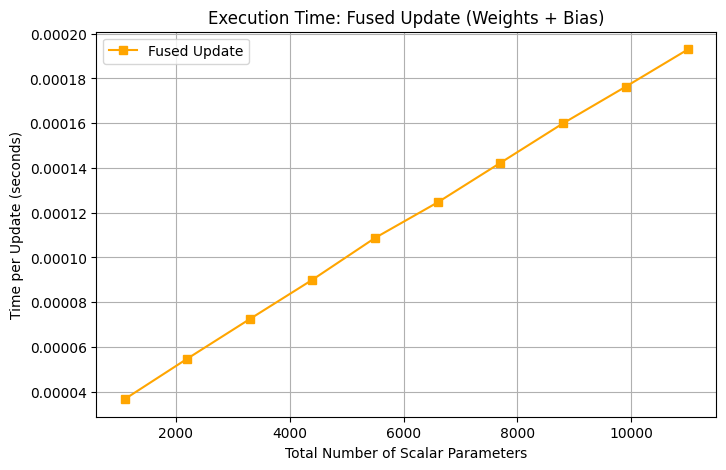

In [3]:
plt.figure(figsize=(8, 5))
plt.plot(total_scalar_params, fused_times, marker='s', label='Fused Update', color='orange')
plt.xlabel('Total Number of Scalar Parameters')
plt.ylabel('Time per Update (seconds)')
plt.title('Execution Time: Fused Update (Weights + Bias)')
plt.legend()
plt.grid(True)
plt.show()

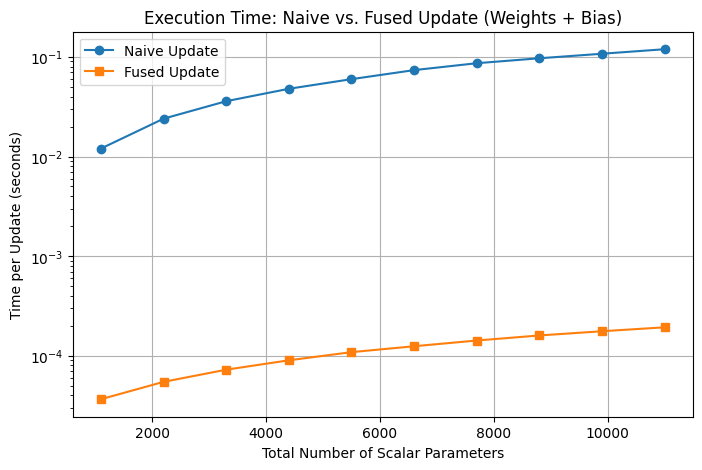

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(total_scalar_params, naive_times, marker='o', label='Naive Update')
plt.plot(total_scalar_params, fused_times, marker='s', label='Fused Update')
plt.yscale('log')
plt.xlabel('Total Number of Scalar Parameters')
plt.ylabel('Time per Update (seconds)')
plt.title('Execution Time: Naive vs. Fused Update (Weights + Bias)')
plt.legend()
plt.grid(True)
plt.show()

NOTE: we assume that all parameters have the same shape so they can be stacked. In real models, parameters are usually of different shapes, and fusing them requires additional work (e.g. grouping similar-shaped tensors).

## S1.4-5 - Multi-tensor apply: Pointer-to-pointer

**NOTE: CUDA Kernel Argument Handling: Evolution of the 4KB Limit**

> Source: https://developer.nvidia.com/blog/cuda-12-1-supports-large-kernel-parameters/

- Pre-CUDA 12.1 Workaround

Previously, developers had to manually copy pointer arrays to GPU memory to bypass the 4KB kernel argument limit. For example, passing a large array of pointers (e.g., `float**` with 1,000 elements) would require:

```
1,000 pointers × 8 bytes/pointer = 8,000 bytes (8KB) // This exceeds the 4KB limit, causing compilation/runtime errors.
````

```c++
// Old approach
float** gpu_ptr_array;
cudaMalloc(&gpu_ptr_array, num_tensors * sizeof(float*)); // Allocate GPU memory for the pointer array
cudaMemcpy(gpu_ptr_array, cpu_ptr_array, num_tensors * sizeof(float*), cudaMemcpyHostToDevice); // Copy CPU pointers to GPU

kernel<<<blocks, threads>>>(gpu_ptr_array, ...);  // Pass only 8B pointer
```

- CUDA 12.1+ Solution

Unified Memory Handling: Kernel arguments >4KB are automatically stored in a driver-managed buffer. No manual cudaMemcpy required for large arguments.

![host_pointer2pointer](./ax-images/host_pointer2pointer.png)
![device_pointer2pointer.png](./ax-images/device_pointer2pointer.png)

In [5]:
import time
import sys
sys.path.insert(0, '..')
from utils import load_cuda, cuda_begin
import re

def get_sig(fname, src):
    res = re.findall(rf'^(.+\s+{fname}\(.*?\))\s*{{?\s*$', src, re.MULTILINE)
    return res[0]+';' if res else None

# Helper functions and CUDA preamble (from your utils)
cuda_begin = cuda_begin + r'''
#include <cuda_runtime.h>
'''

# --------------------------
# Bad Approach Implementation
# --------------------------
bad_cuda_src = cuda_begin + r'''
__global__ void single_add_kernel(float* a, float* b, float* out, int size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if(idx < size) out[idx] = a[idx] + b[idx];
}

torch::Tensor bad_add(torch::Tensor a, torch::Tensor b) {
    CHECK_INPUT(a); CHECK_INPUT(b);
    auto out = torch::zeros_like(a);
    const int size = a.numel();
    const int threads = 256;
    const int blocks = (size + threads - 1) / threads;
    single_add_kernel<<<blocks, threads>>>(a.data_ptr<float>(), b.data_ptr<float>(), out.data_ptr<float>(), size);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return out;
}
'''

fname_bad='bad_add' 
cpp_src = get_sig(fname_bad, bad_cuda_src)
bad_module = load_cuda(bad_cuda_src, cpp_src, ["bad_add"])

In [6]:
# --------------------------
# Good Approach Implementation
# --------------------------

good_cuda_src = cuda_begin + r'''
__global__ void bulk_add_kernel(
    float** a_ptrs, 
    float** b_ptrs,
    float** out_ptrs,
    int tensor_size,
    int num_tensors
) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    if(tid >= num_tensors) return;

    float* a = a_ptrs[tid];
    float* b = b_ptrs[tid];
    float* out = out_ptrs[tid];

    for(int i=0; i<tensor_size; ++i) {
        out[i] = a[i] + b[i];
    }
}

torch::Tensor fused_add(torch::Tensor a_ptrs, torch::Tensor b_ptrs, torch::Tensor out_ptrs, int tensor_size) {
    CHECK_INPUT(a_ptrs); CHECK_INPUT(b_ptrs); CHECK_INPUT(out_ptrs);
    
    const int num_tensors = a_ptrs.size(0);
    const int threads = 256;
    const int blocks = (num_tensors + threads - 1) / threads;
    
    bulk_add_kernel<<<blocks, threads>>>(
        reinterpret_cast<float**>(a_ptrs.data_ptr<int64_t>()),
        reinterpret_cast<float**>(b_ptrs.data_ptr<int64_t>()),
        reinterpret_cast<float**>(out_ptrs.data_ptr<int64_t>()),
        tensor_size,
        num_tensors
    );
    
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return out_ptrs;
}
'''
fname_fused="fused_add"
cpp_src_fused = get_sig(fname_fused, good_cuda_src)
# cpp_src_good = "torch::Tensor good_add(torch::Tensor a_ptrs, torch::Tensor b_ptrs, torch::Tensor out_ptrs, int tensor_size);"
fused_module = load_cuda(good_cuda_src, cpp_src_fused, ["fused_add"])

In [7]:
# --------------------------
# Benchmark and Verification
# --------------------------
def test_approaches():
    # Set seeds for reproducibility
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
    num_tensors = 1000
    tensor_size = 1024
    
    # Create reproducible tensor lists
    a_list = [torch.randn(tensor_size, device='cuda') for _ in range(num_tensors)]
    b_list = [torch.randn(tensor_size, device='cuda') for _ in range(num_tensors)]
    out_list = [torch.empty_like(a) for a in a_list]

    # Create pointer arrays for good approach
    a_ptrs = torch.tensor([t.data_ptr() for t in a_list], dtype=torch.int64, device='cuda')
    b_ptrs = torch.tensor([t.data_ptr() for t in b_list], dtype=torch.int64, device='cuda')
    out_ptrs = torch.tensor([t.data_ptr() for t in out_list], dtype=torch.int64, device='cuda')

    # Warm-up
    for _ in range(5):
        _ = bad_module.bad_add(a_list[0], b_list[0])
        _ = fused_module.fused_add(a_ptrs, b_ptrs, out_ptrs, tensor_size)
    torch.cuda.synchronize()

    # Bad approach timing
    start = time.time()
    for i in range(num_tensors):
        bad_module.bad_add(a_list[i], b_list[i])
    torch.cuda.synchronize()
    bad_time = time.time() - start

    # Good approach timing
    start = time.time()
    fused_module.fused_add(a_ptrs, b_ptrs, out_ptrs, tensor_size)
    torch.cuda.synchronize()
    good_time = time.time() - start

    # Verification
    for i in range(num_tensors):
        bad_result = bad_module.bad_add(a_list[i], b_list[i])
        good_result = out_list[i]
        assert torch.allclose(bad_result, good_result, atol=1e-6), f"Mismatch at tensor {i}"

    print(f"Bad approach: {bad_time:.4f}s (1000 kernel launches)")
    print(f"Good approach: {good_time:.4f}s (1 kernel launch - Batch process multiple element-wise tensor additions in a single CUDA kernel launch)")
    print(f"Speedup: {bad_time/good_time:.1f}x")

if __name__ == "__main__":
    test_approaches()

Bad approach: 0.0086s (1000 kernel launches)
Good approach: 0.0005s (1 kernel launch - Batch process multiple element-wise tensor additions in a single CUDA kernel launch)
Speedup: 17.2x


In [8]:
# --------------------------
# Approach That Hits 32KB Limit
# --------------------------

def create_argument_limit_test(num_pointers):
    # Generate kernel with N pointer arguments
    kernel_args = ', '.join([f'float* ptr{i}' for i in range(num_pointers)])
    kernel_body = ' + '.join([f'ptr{i}[0]' for i in range(num_pointers)])
    
    cuda_src = cuda_begin + f'''
__global__ void arg_limit_kernel({kernel_args}) {{
    float sum = {kernel_body};
}}

torch::Tensor test_limit(torch::Tensor dummy) {{
    CHECK_CUDA(dummy);
    arg_limit_kernel<<<1, 1>>>(
        {"".join(['dummy.data_ptr<float>(), ']*num_pointers)[:-2]}
    );
    return dummy;
}}
'''
    return cuda_src

def test_argument_limit():
    # Calculate theoretical limit
    max_allowed = 32764 // 8  # 4095 pointers (8 bytes each) Source: https://developer.nvidia.com/blog/cuda-12-1-supports-large-kernel-parameters#:~:text=increases,above
    test_cases = [
        ("Under limit", max_allowed - 1),
        ("At limit", max_allowed),
        ("Over limit", max_allowed + 1)
    ]

    for name, num_pointers in test_cases:
        try:
            print(f"Testing {num_pointers} pointers ({num_pointers*8}B)...")
            
            # Generate custom kernel
            cuda_src = create_argument_limit_test(num_pointers)

            cpp_src_limit = get_sig("test_limit", cuda_src)
            
            # Attempt to compile
            mod = load_cuda(
                cuda_src,
                cpp_src_limit,
                ['test_limit'],
            )

            load_cuda(good_cuda_src, cpp_src_fused, ["fused_add"])
            
            # Test with dummy tensor
            dummy = torch.zeros(1, device='cuda')
            mod.test_limit(dummy)
            print(f"✅ {name} ({num_pointers} pointers) succeeded")
            
        except Exception as e:
            print(f"❌ {name} ({num_pointers} pointers) failed")
            print(str(e)[:200])

if __name__ == "__main__":
    test_argument_limit()

Testing 4094 pointers (32752B)...
✅ Under limit (4094 pointers) succeeded
Testing 4095 pointers (32760B)...
✅ At limit (4095 pointers) succeeded
Testing 4096 pointers (32768B)...
❌ Over limit (4096 pointers) failed
Error building extension 'test_limit_v2': [1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=test_limit_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstd
